In [1]:
import torch
import evaluate
import numpy as np
import matplotlib.pyplot as plt
from src.preprocessing import Data
from peft import LoraConfig, get_peft_model
from transformers import BertForSequenceClassification, TrainingArguments, Trainer

In [2]:
batch_size=32
max_len = 64
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu" )
data = Data(bert_token = True, train_file = "data/train_dataset.csv", test_file = "data/test_dataset.csv", val_file = "data/validation_dataset.csv", max_length=max_len)
train_dataset, val_dataset, test_dataset = data.load_data_transformers_like(device=device)

In [3]:
# Parameters 
if data.output_dim is not None:
    output_dim: int= data.output_dim 
else:
    raise "Output dimension is unknown"

n_epochs = 15
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu" )
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=output_dim, ignore_mismatched_sizes=True)
metric = evaluate.load("accuracy")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
lora_config = LoraConfig(
    r=8, # Taille des matrices de basse-rang
    lora_alpha=16, # Facteur de mise à l’échelle
    lora_dropout=0.1, # Dropout pour éviter le sur-apprentissage
    bias="none",
    task_type="SEQ_CLS" # Pour classification de texte (Sequence Classification)
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()  # Vérifier que seuls les paramètres LoRA sont entraînables

trainable params: 299,526 || all params: 109,786,380 || trainable%: 0.2728


In [5]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [6]:
training_args = TrainingArguments(
    output_dir="results",
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=n_epochs,
    logging_dir="logs",
    load_best_model_at_end=True,
    save_strategy="epoch",
    logging_strategy="epoch",
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [7]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.469400,1.159962,0.566500
2,1.081400,0.920172,0.644500
3,0.842300,0.717126,0.734000
4,0.686100,0.596334,0.775500
5,0.585100,0.497772,0.816000
6,0.511100,0.425944,0.848000
7,0.461700,0.378472,0.867000
8,0.423800,0.358636,0.872500
9,0.392100,0.328681,0.892500
10,0.370700,0.310725,0.899500


TrainOutput(global_step=7500, training_loss=0.5671248352050782, metrics={'train_runtime': 8935.409, 'train_samples_per_second': 26.859, 'train_steps_per_second': 0.839, 'total_flos': 7921219461120000.0, 'train_loss': 0.5671248352050782, 'epoch': 15.0})

In [8]:
logs = trainer.state.log_history

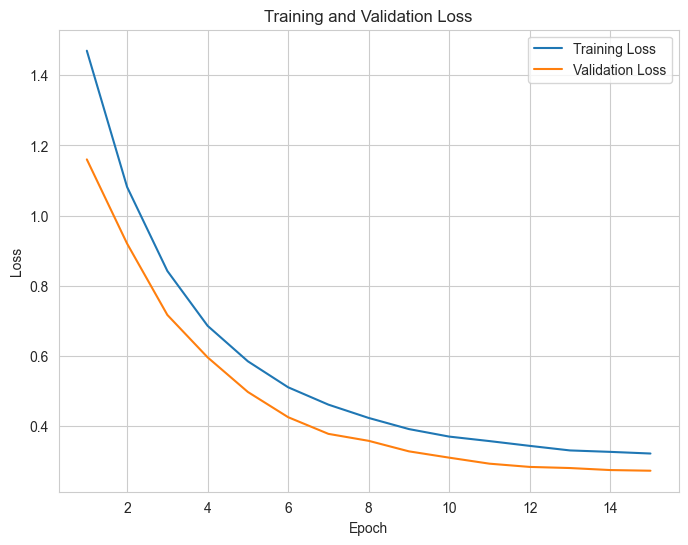

In [9]:
train_loss = [log["loss"] for log in logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in logs if "eval_loss" in log]
epochs = [log["epoch"] for log in logs if "epoch" in log and "loss" in log]
eval_epochs = [log["epoch"] for log in logs if "epoch" in log and "eval_loss" in log]

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(eval_epochs, eval_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [10]:
torch.save(model.state_dict(), 'models/lora_bert_model.pth')